In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.4 MB 35 kB/s 
     |████████████████████████████████| 199 kB 44.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=fec9cfd7b195132f6643a4cbaa9698ab63422f61626d72973e0da03a891f700a
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [2]:
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession\
        .builder\
        .master('local[*]')\
        .getOrCreate()
sc = spark.sparkContext

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#change the directory
%cd /content/drive/My Drive/Colab Notebooks/big-data-Colab/
#pwd
!ls

/content/drive/My Drive/Colab Notebooks/big-data-Colab
'10.Spark-Classification.ipynb .ipynb'	 JosephNikhilReddy_MT_Q1_B.txt
 11.ipynb				 JosephNikhilReddy_MT_Q2_A.txt
 11.Spark-Classifier-evaluation.ipynb	 JosephNikhilReddy_MT_Q2_B.txt
 12.Spark-Clustering.ipynb		 JosephNikhilReddy_MT_Q3_A.txt
 2.DataCopy.ipynb			 JosephNikhilReddy_MT_Q3_B.txt
 2.WordCount.ipynb			 make_join2data.py
 4.MR-DataJoin.ipynb			'Midterm Section2 Q1.ipynb'
 4.MR-WordCount.ipynb			'Midterm Section2 Q2.ipynb'
 5.MR-DataJoin2.ipynb			'Midterm Section2 Q3.ipynb'
 6.MR-WordCountReducer.ipynb		 minute_weather.csv.gz
 7.Spark-WordCount.ipynb		 MT_Q1_make_data.py
 8.Spark-SQL.ipynb			 MT_Q2_make_data.py
 8.Spark-Streaming.ipynb		 MT_Q3_make_data.py
 9.Spark-Handling-missing-values.ipynb	 out
 ad-clicks.csv.gz			 out0
 BigData.ipynb				 out2
 buy-clicks.csv.gz			 out3
 daily_weather.csv			 outDataJoin
 game-clicks.csv.gz			 outDataJoin2
 hadoop-3.3.4				 predictions.csv
 hadoop-3.3.4.tar.gz			 Q1out
 join1_FileA.txt

In [5]:
!cp utils.py /content/utils.py

In [6]:
from pyspark.sql import SQLContext
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
import utils
%matplotlib inline

In [7]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('/content/drive/My Drive/Colab Notebooks/big-data-Colab/minute_weather.csv.gz',
                          format='com.databricks.spark.csv',
                          header = 'true',
                          inferSchema='true')

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [8]:
df.count()

1587257

In [9]:
filteredDF = df.filter((df.rowID % 10) == 0)
filteredDF.count()


158726

In [10]:
filteredDF.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
rowID,158726,793625.0,458203.9375103623,0,1587250
air_pressure,158726,916.830161410269,3.0517165528304218,905.0,929.5
air_temp,158726,61.8515891536367,11.83356921064173,31.64,99.5
avg_wind_direction,158680,162.15610032770354,95.27820101905971,0.0,359.0
avg_wind_speed,158680,2.7752148979077846,2.0576239697426213,0.0,31.9
max_wind_direction,158680,163.46214393748426,92.45213853838614,0.0,359.0
max_wind_speed,158680,3.400557726241582,2.4188016208098935,0.1,36.0
min_wind_direction,158680,166.77401688933702,97.44110914784639,0.0,359.0
min_wind_speed,158680,2.1346641038568777,1.742112505242431,0.0,31.6


In [11]:
filteredDF.filter(filteredDF.rain_accumulation ==0.0).count()

157812

In [12]:
filteredDF.filter(filteredDF.rain_accumulation == 0.0).count()/filteredDF.count()

0.9942416491312073

In [13]:
filteredDF =df.filter((df.rowID % 5) == 0)
filteredDF.count()

317452

In [21]:
workingDF = filteredDF.drop('rain_accumulation').drop('rain_duration').drop('hpwren_timestamp')

In [22]:
before = workingDF.count()
workingDF = workingDF.na.drop()
after = workingDF.count()
before - after

87

In [23]:
workingDF.columns

['rowID',
 'air_pressure',
 'air_temp',
 'avg_wind_direction',
 'avg_wind_speed',
 'max_wind_direction',
 'max_wind_speed',
 'min_wind_direction',
 'min_wind_speed',
 'relative_humidity']

In [24]:
featuresUsed = ['air_pressure','air_temp','avg_wind_direction','avg_wind_speed','max_wind_direction','max_wind_speed','relative_humidity']
assembler = VectorAssembler(inputCols=featuresUsed, outputCol="features_unscaled")
assembled = assembler.transform(workingDF)

In [25]:
scaler = StandardScaler(inputCol= "features_unscaled", outputCol="features",withStd=True, withMean=True)
scalerModel = scaler.fit(assembled)
scaledData = scalerModel.transform(assembled)


In [26]:
scaledData = scaledData.select("features","rowID")

elbowset= scaledData.filter((scaledData.rowID % 3) == 0).select("features")
elbowset.persist()

DataFrame[features: vector]

In [27]:
clusters = range(2,31)
wsseList = utils.elbow(elbowset, clusters)


Training for cluster size 2 
......................WSSE = 229829.62730917166 
Training for cluster size 3 
......................WSSE = 206667.97217192836 
Training for cluster size 4 
......................WSSE = 189032.76411117517 
Training for cluster size 5 
......................WSSE = 183908.85934855405 
Training for cluster size 6 
......................WSSE = 168753.61777414245 
Training for cluster size 7 
......................WSSE = 163573.65551496902 
Training for cluster size 8 
......................WSSE = 157602.63806143656 
Training for cluster size 9 
......................WSSE = 154162.2041471681 
Training for cluster size 10 
......................WSSE = 147560.0739390756 
Training for cluster size 11 
......................WSSE = 142568.61366921087 
Training for cluster size 12 
......................WSSE = 140348.28468644072 
Training for cluster size 13 
......................WSSE = 138085.85155486292 
Training for cluster size 14 
......................WSSE = 135

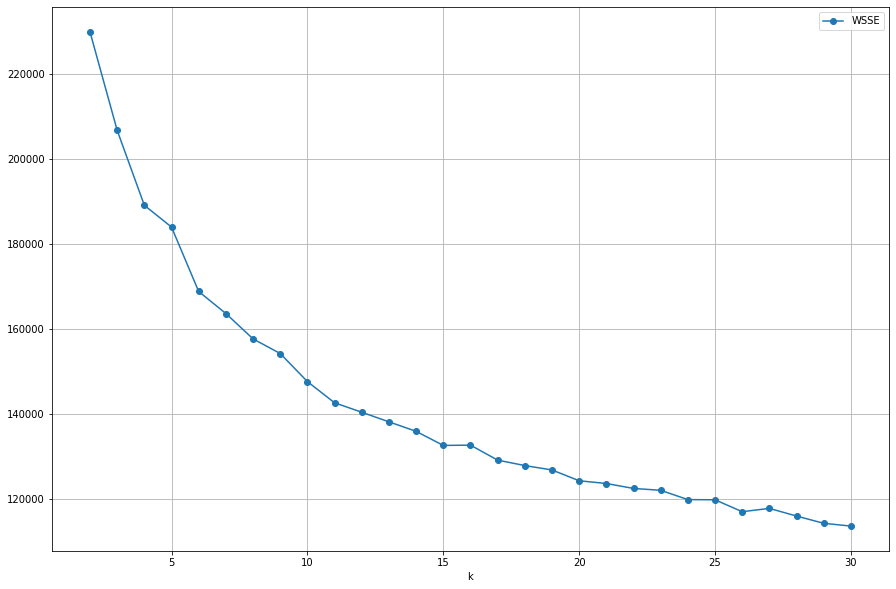

In [28]:
utils.elbow_plot(wsseList, clusters)

In [29]:
scaledDataFeat = scaledData.select("features")
scaledDataFeat.persist()

DataFrame[features: vector]

In [30]:
kmeans = KMeans(k=12, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [31]:
centers = model.clusterCenters()
centers

[array([-0.41371639,  0.91115717, -1.28295792, -0.64365915, -1.14174376,
        -0.66254321, -0.50866645]),
 array([-1.13405263, -0.98206739,  0.42825391,  1.65363304,  0.52394692,
         1.62356573,  1.041717  ]),
 array([ 1.21650214, -0.1483029 ,  0.54308773, -0.5152843 ,  0.0575486 ,
        -0.50618601, -0.68300665]),
 array([-0.21868536, -1.06702819,  0.58400872, -0.28586968,  0.57932563,
        -0.27836341,  1.26688769]),
 array([ 1.08823435, -0.3174842 , -1.14193499,  2.80488872, -1.05336428,
         2.93193148, -1.13123166]),
 array([ 0.20374155,  0.75431507,  1.36199819, -0.64008489,  1.62959547,
        -0.58957049, -0.65878157]),
 array([-0.32044202,  0.74805924,  0.48213415, -0.65901481,  0.06119052,
        -0.66082784, -0.41886728]),
 array([-0.25722533,  0.60121685,  0.42108491,  0.63870583,  0.50534748,
         0.58390927, -0.1346628 ]),
 array([ 1.73386361, -0.35196375, -1.1406635 ,  1.10463637, -1.02935562,
         1.19347273, -1.08742726]),
 array([ 0.33938895

In [32]:
P = utils.pd_centers(featuresUsed, centers)

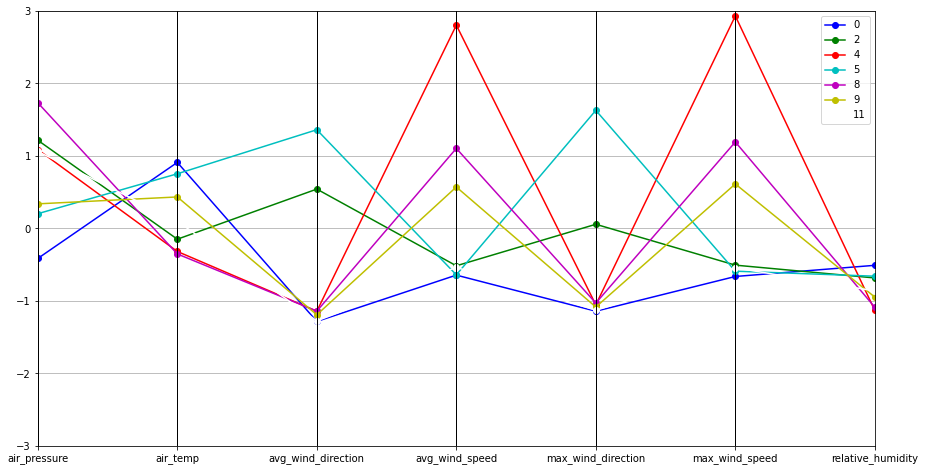

In [33]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

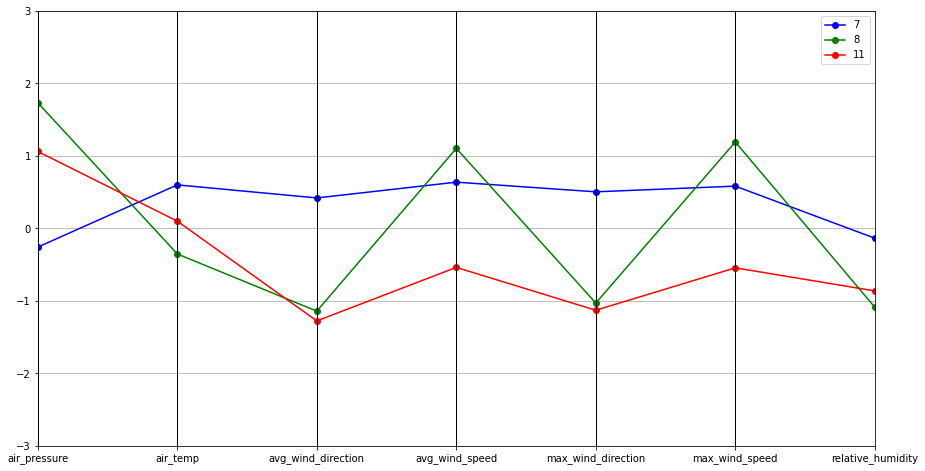

In [34]:
utils.parallel_plot(P.iloc[[7,8,11]], P)

In [35]:
kmeans = KMeans(k=20, seed=1)
model = kmeans.fit(scaledDataFeat)
transformed = model.transform(scaledDataFeat)

In [36]:
centers = model.clusterCenters()
centers

[array([-1.18861487, -1.1374264 ,  0.30456026, -0.34335859,  0.38671554,
        -0.33886769,  1.43498815]),
 array([ 0.26268176, -0.98147687,  1.34667697, -0.58933548,  1.63101393,
        -0.52197779,  0.98543643]),
 array([ 1.09811017, -0.31399341, -1.16489328,  2.93181926, -1.07103641,
         3.06501457, -1.15368836]),
 array([-1.62403071, -1.38012943,  0.38069182,  1.25378966,  0.50564756,
         1.26368745,  1.49177353]),
 array([-0.81176381,  0.13662328,  0.3148872 ,  0.12476559,  0.4273206 ,
         0.09200722,  0.19994078]),
 array([ 1.17405189, -0.10602204,  0.6477835 , -0.65068219,  0.86946055,
        -0.64018348, -0.80941749]),
 array([-0.40027019,  0.73647032,  0.1512449 , -0.81024578,  0.34605952,
        -0.82235411, -0.45938861]),
 array([-0.57333488,  0.88552727, -1.29378303, -0.6159715 , -1.16435505,
        -0.63785055, -0.42570905]),
 array([ 1.64954925, -0.37701696, -1.13941028,  1.41290771, -1.03386526,
         1.51352571, -1.10518221]),
 array([ 0.13221359

In [37]:
P = utils.pd_centers(featuresUsed, centers)

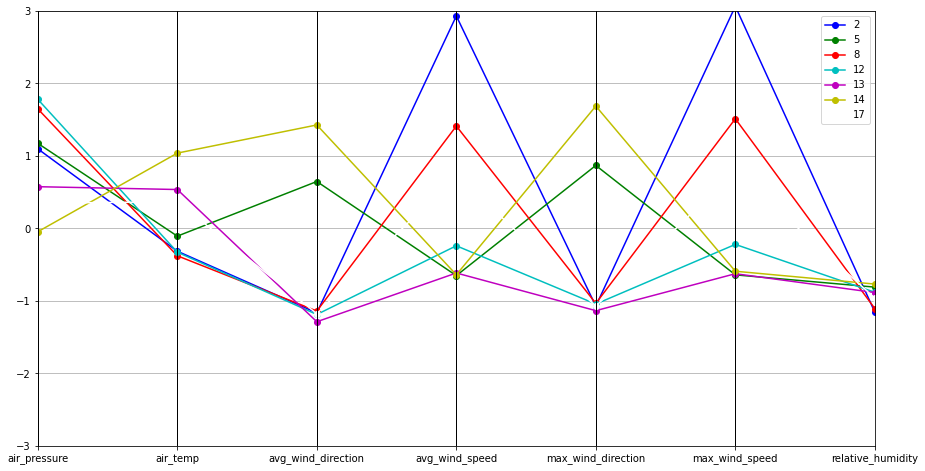

In [38]:
utils.parallel_plot(P[P['relative_humidity'] < -0.5], P)

In [39]:
sqlContext = SQLContext(sc)
df = sqlContext.read.load('/content/drive/My Drive/Colab Notebooks/big-data-Colab/minute_weather.csv.gz',
                          format='com.databricks.spark.csv',
                          header = 'true',
                          inferSchema='true')

/usr/local/lib/python3.8/dist-packages/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [40]:
filteredDF =df.filter((df.rowID % 10) == 0).dropna()
filteredDF.corr('min_wind_speed', 'avg_wind_speed')

0.970862063189086